In [1]:
import pysam
import os
import sys
directory_path = os.path.abspath(os.path.join('../src/'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
    
from read_process import get_contig_lengths_dict,\
incorporate_replaced_pos_info,incorporate_insertions_and_deletions,\
get_positions_from_md_tag,reverse_complement,get_edit_information,get_edit_information_wrapper,\
has_edits,get_dataframe_from_barcode_dict


# An example on a bam for just one cell barcode (split from the original bam)

### in 10X's bam file, xf=25 means that read is uniquely mapped to a genome, and was used for counting UMI. So we should only look at reads with xf=25 from the 10X bam.

In [2]:
barcode = 'AAACCCAAGATTGCGG'
bampath = '../data/group0_data/filtered_keep_xf25_possorted_genome_with_header.bam_MD.bam_MD-{}-1.bam'.format(barcode)

In [3]:
samfile = pysam.AlignmentFile(bampath, "rb")

# Helper functions

In [4]:
    
def print_read_info(read):
    md_tag = read.get_tag('MD')
    read_id = read.query_name
    cigar_string = read.cigarstring
    barcode = read.get_tag('CR')
    print('MD tag', md_tag)
    print("CIGAR tag", cigar_string)
    print('barcode', barcode)
    

# Full test

In [5]:
from collections import defaultdict
import time
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# TOLERANCES/THRESHOLD FOR FILTERING
max_edit_tolerance = 5
dist_from_end_tolerance = 5
base_quality_threshold = 37
mapping_quality_threshold = 255

# DICTIONARIES TO FILL WITH EDIT INFORMATION
barcode_to_position_to_alts = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:defaultdict())))) 
skipped_for_deletions_count = 0 
wrong_barcode = []

example_dataframe_per_contig = {}
contig_lengths_dict = get_contig_lengths_dict(samfile)
contigs = [i for i in contig_lengths_dict.keys() if len(i) < 5]

# THE HEAVY LIFTING
total_reads = 0
for contig in contigs:
    print(contig)
    reads_for_contig = samfile.fetch(contig, 0, contig_lengths_dict.get(contig))

    reads_kept = 0
    for i, read in enumerate(reads_for_contig):
        
        if not has_edits(read):
            continue
        if read.is_secondary:
            continue
            
        md_tag = read.get_tag('MD')
            
        is_reverse = read.is_reverse
        strand = '+'
        if is_reverse:
            strand = '-'

        reference_start = read.reference_start
        reference_end = read.reference_end
        read_id = read.query_name

        if '^' in md_tag:
            # FOR NOW SKIP DELETIONS, THEY ARE TRICKY TO PARSE...
            skipped_for_deletions_count += 1
            continue

        read_barcode = read.get_tag('CR')
        
        # READ FILTERING DONE
        reads_kept += 1
        
        alt_bases, ref_bases, qualities, positions_replaced = get_edit_information_wrapper(read, not is_reverse)
        
        for alt, ref, qual, pos in zip(alt_bases, ref_bases, qualities, positions_replaced):
            assert(alt != ref)
            updated_position = pos+reference_start
            if is_reverse:
                alt = reverse_complement(alt)
                ref = reverse_complement(ref)

            distance_from_read_end = np.min([updated_position - reference_start, reference_end - updated_position])
            
            barcode_to_position_to_alts[read_barcode][contig]['{}_{}'.format(updated_position, ref)]\
            [alt][read_id] = strand, distance_from_read_end, qual
        if reads_kept > 100000:
            break
        
    total_reads += reads_kept
    

1
10
11
12
13
14
15
16
17
18
19
2
3
4
5
6
7
8
9
MT
X
Y


In [6]:
print("{} total reads".format(total_reads))

6586 total reads


# BUILD DATATFRAME

In [7]:
example_dataframe = get_dataframe_from_barcode_dict(barcode_to_position_to_alts)
print(len(example_dataframe))

12360


In [9]:
example_dataframe.head()

,barcode,contig,position_ref,alt,read_id,strand,dist_from_read_end,quality,ref,position
0,AAACCCAAGATAGCGG,1,3210993_G,T,A01535:287:H3JJHDSX7:1:1256:24496:23531,-,44,11,G,3210993
1,AAACCCAAGATAGCGG,1,3210998_C,A,A01535:287:H3JJHDSX7:1:1256:24496:23531,-,39,11,C,3210998
2,AAACCCAAGATAGCGG,12,116256160_C,A,A01535:287:H3JJHDSX7:1:1301:12545:32581,-,15,11,C,116256160
3,AAACCCAAGATAGCGG,12,116256165_G,T,A01535:287:H3JJHDSX7:1:1301:12545:32581,-,20,11,G,116256165
4,AAACCCAAGATAGCGG,14,24493549_T,G,A01535:287:H3JJHDSX7:1:1525:5475:21371,+,79,11,T,24493549


# FILTER DATAFRAME

Filtering out 358 hyperedited reads that had more than 5 edits
12360
9618
5569


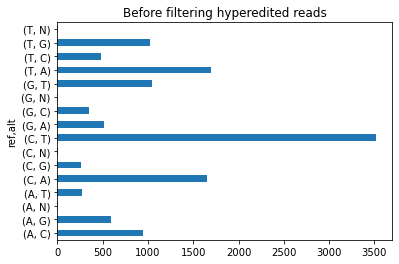

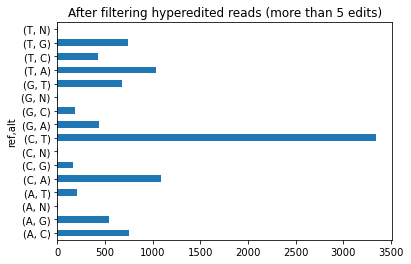

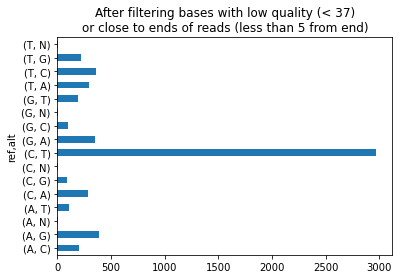

In [11]:
num_edits_per_read = pd.DataFrame(example_dataframe.groupby('read_id').count().barcode)
num_edits_per_read.columns = ['edits']

hyperedited_reads = num_edits_per_read[num_edits_per_read.edits > max_edit_tolerance]
print("Filtering out {} hyperedited reads that had more than {} edits".format(len(hyperedited_reads),
                                                                             max_edit_tolerance))

print(len(example_dataframe))
example_dataframe_filtered = example_dataframe[~example_dataframe.read_id.isin(hyperedited_reads.index)]
print(len(example_dataframe_filtered))
example_dataframe.groupby(['ref', 'alt']).count().barcode.plot(kind='barh')
plt.title("Before filtering hyperedited reads")
plt.figure()
example_dataframe_filtered.groupby(['ref', 'alt']).count().barcode.plot(kind='barh')
plt.title("After filtering hyperedited reads (more than {} edits)".format(max_edit_tolerance))

# Filter for distance from read end and base quality
example_dataframe_filtered = example_dataframe[(example_dataframe.dist_from_read_end > dist_from_end_tolerance) & (example_dataframe.quality.astype(int) >= base_quality_threshold)]
print(len(example_dataframe_filtered))
plt.figure()
example_dataframe_filtered.groupby(['ref', 'alt']).count().barcode.plot(kind='barh')
_ = plt.title("After filtering bases with low quality (< {})\nor close to ends of reads (less than {} from end)".format(base_quality_threshold, dist_from_end_tolerance))


In [12]:
example_new_ct =  example_dataframe_filtered[(example_dataframe_filtered.ref == 'C') & (example_dataframe_filtered.alt == 'T')].sort_values('position')

In [13]:
len(example_new_ct)

2972

In [14]:
example_new_ct = example_new_ct[example_new_ct.dist_from_read_end > 5]

In [15]:
len(example_new_ct)

2972

# Extract only reads for a barcode

In [16]:
# Get edits for barcode

example = pd.read_csv(
    '../data/group0_data/filtered_keep_xf25_possorted_genome_with_header.bam_MD.bam_MD-{}-1.bam.combined.readfiltered.formatted.varfiltered.snpfiltered.ranked.bed'.format(barcode),
    sep='\t', names=['contig', 'start', 'end', 'score', 'coverage', 'strand'])

comparison_vals = []
for contig in contigs:
    print('contig {}'.format(contig))
    example_new_ct_for_contig = example_new_ct[example_new_ct.contig == contig]
    example_new_ct_for_contig.index = example_new_ct_for_contig.position

    example_old_ct_for_contig = example[example.contig == contig]
    example_old_ct_for_contig.index = example_old_ct_for_contig.start

    # Which overlap?

    
    overlapping = example_old_ct_for_contig.join(example_new_ct_for_contig, rsuffix='_2', how='inner').drop_duplicates(['contig', 'start', 'end', 'score'])
    
    print("\tNumber of sites in old version: {}".format(len(example_old_ct_for_contig)))
    print("\tNumber of sites recapitulated: {}".format(len(overlapping)))
    
    comparison_vals.append([len(example_old_ct_for_contig), len(overlapping), len(example_new_ct_for_contig)])


contig 1
	Number of sites in old version: 11
	Number of sites recapitulated: 10
contig 10
	Number of sites in old version: 15
	Number of sites recapitulated: 13
contig 11
	Number of sites in old version: 32
	Number of sites recapitulated: 29
contig 12
	Number of sites in old version: 21
	Number of sites recapitulated: 18
contig 13
	Number of sites in old version: 3
	Number of sites recapitulated: 2
contig 14
	Number of sites in old version: 11
	Number of sites recapitulated: 10
contig 15
	Number of sites in old version: 19
	Number of sites recapitulated: 17
contig 16
	Number of sites in old version: 5
	Number of sites recapitulated: 5
contig 17
	Number of sites in old version: 17
	Number of sites recapitulated: 15
contig 18
	Number of sites in old version: 1
	Number of sites recapitulated: 1
contig 19
	Number of sites in old version: 23
	Number of sites recapitulated: 22
contig 2
	Number of sites in old version: 20
	Number of sites recapitulated: 20
contig 3
	Number of sites in old ver

# Which sites are we recovering?

In [17]:
recapitulation_summary = pd.DataFrame(comparison_vals, index=contigs, columns=['Previous sites', 'Overlapping sites', 'New sites'])

Text(0.5, 1.0, 'Sites from old approach recapitulated with new approach')

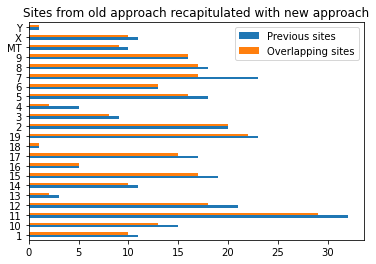

In [18]:
recapitulation_summary[['Previous sites', 'Overlapping sites']].plot(kind='barh')
plt.title("Sites from old approach recapitulated with new approach")